In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from scipy.stats import shapiro
from arch import arch_model

In [2]:
train_data = pd.read_csv('Data/train_data.csv')
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.set_index('date', inplace=True)
train_data = train_data.resample('D').asfreq().fillna(method='ffill')
train_data = train_data[train_data.index >= '2022-01-01']

In [3]:
#Creating Differences for ADF test

train_data["Temp. First Difference"] = train_data["mean"] - train_data["mean"].shift(1)
train_data["Seasonal Difference"] = train_data["mean"] - train_data["mean"].shift(365)
train_data["Seasonal First Difference"] = train_data["Temp. First Difference"] - train_data[
    "Temp. First Difference"
].shift(365)

In [4]:
def adf_check(series):
    
        results = adfuller(series, autolag='AIC')
        print()
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print("Augmented Dickey-Fuller Unit Root Test:")
        labels = [
            "ADF Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ]
        
        for value, label in zip(results, labels):
            print(f"{label} : {value}")
            
        if results[1] <= 0.05:
            print("Reject the null hypothesis: Series is stationary and has no unit root")
        else:
            print("Weak evidence against the null hypothesis: Series is non-stationary and has a unit root")
            
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        

adf_check(train_data['mean'])

adf_check(train_data["Seasonal Difference"].dropna())


adf_check(train_data["Seasonal First Difference"].dropna())
    


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmented Dickey-Fuller Unit Root Test:
ADF Test Statistic : -2.0599794018608906
p-value : 0.26090844597924523
#Lags Used : 9
Number of Observations Used : 811
Weak evidence against the null hypothesis: Series is non-stationary and has a unit root
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmented Dickey-Fuller Unit Root Test:
ADF Test Statistic : -6.2888883899244075
p-value : 3.64035013510003e-08
#Lags Used : 2
Number of Observations Used : 453
Reject the null hypothesis: Series is stationary and has no unit root
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmented Dickey-Fuller Unit Root Test:
ADF Test Statistic : -10.092429213111695
p-value : 1.1130888587301576e-17
#Lags Used : 8
Number of Observations Used : 446
Reject the null hypothesis: Series is stationary and has no unit root
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


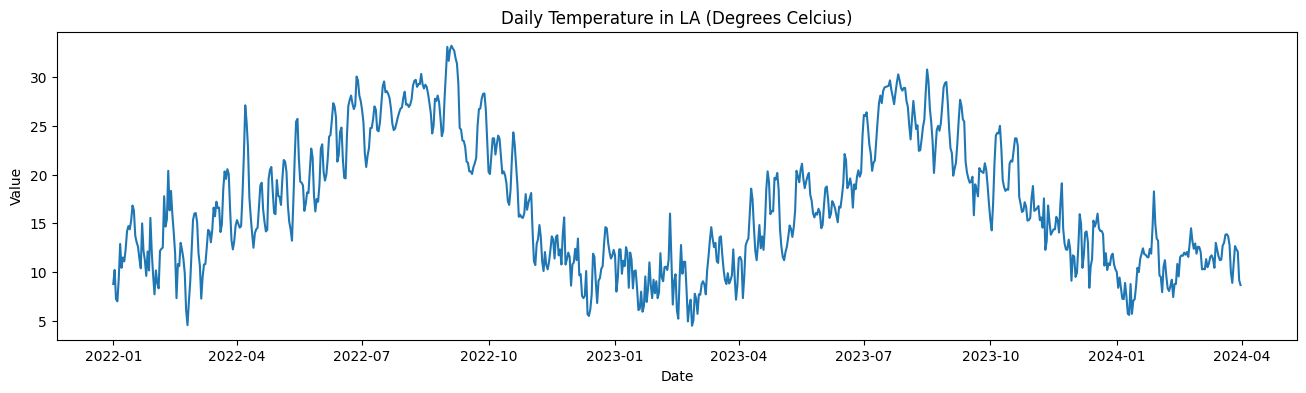

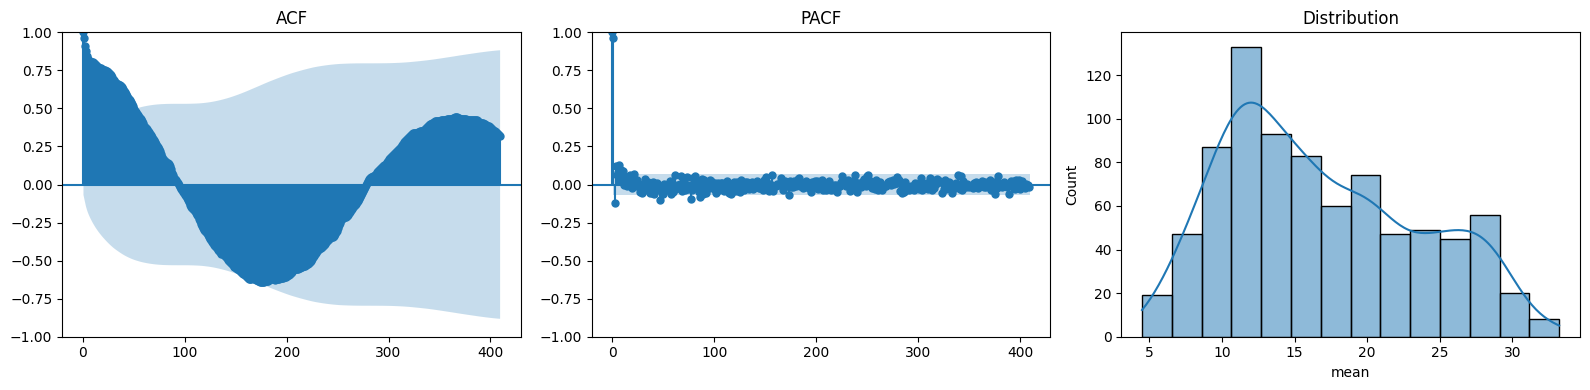

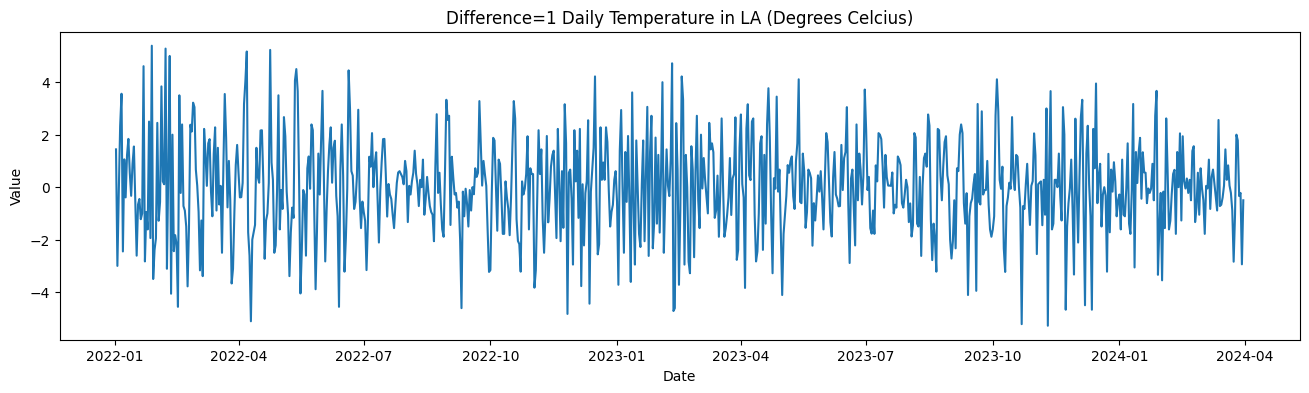

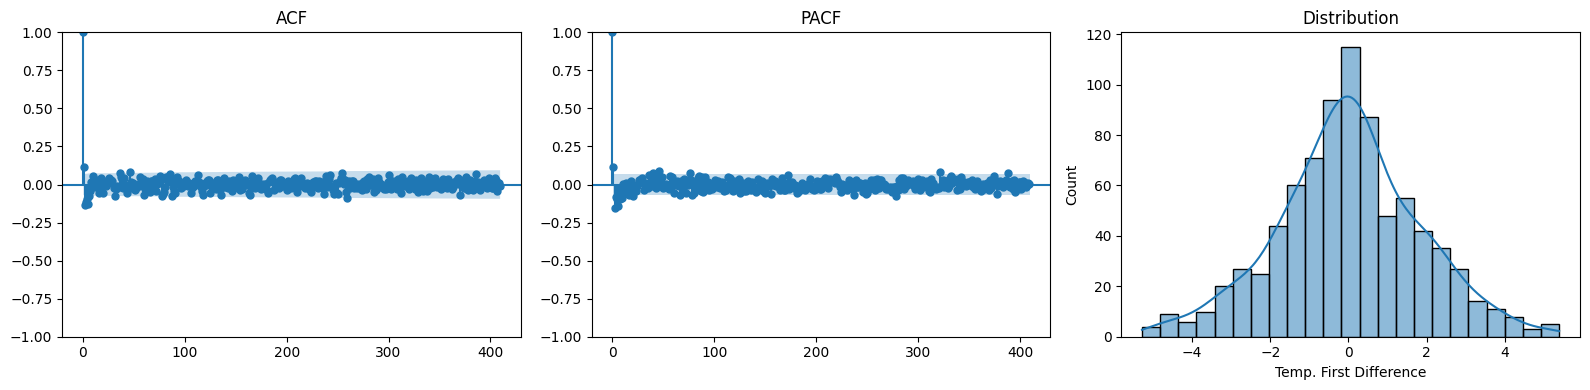

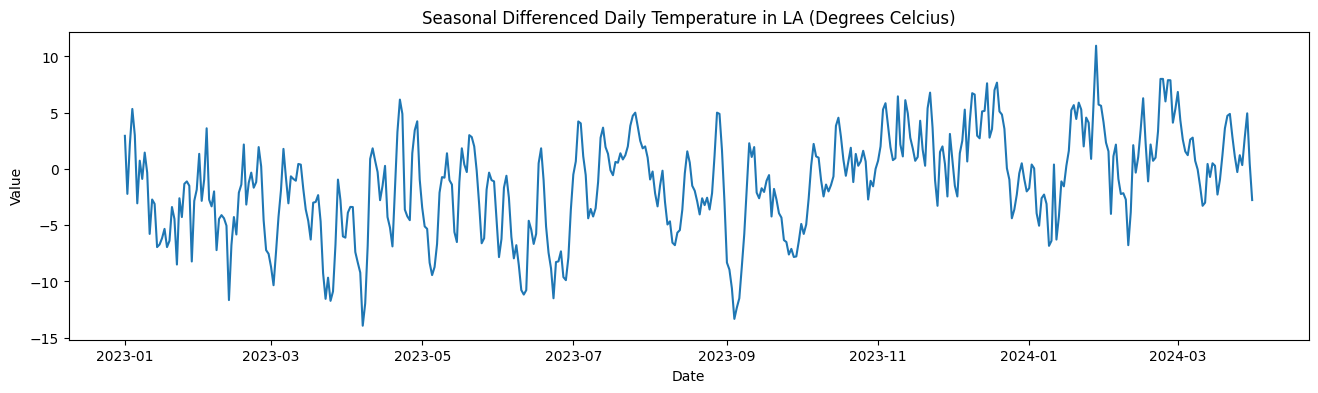

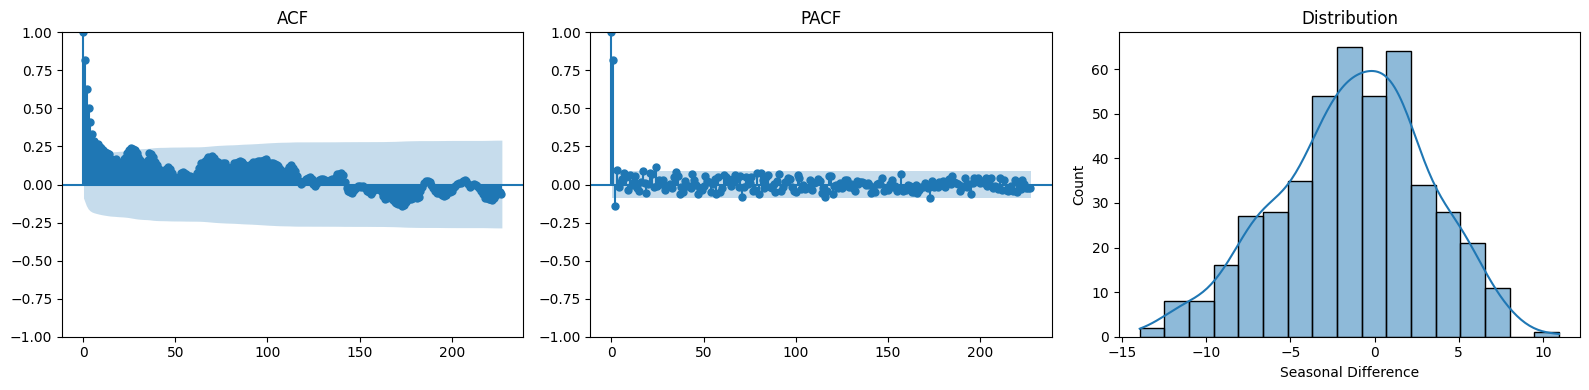

In [5]:
def plot_data_properties(data, ts_plot_name="Time Series plot"):
    data = data.dropna()

    plt.figure(figsize=(16,4))
    plt.plot(data)
    plt.title(ts_plot_name)
    plt.ylabel('Value')
    plt.xlabel('Date')

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    plot_acf(data, ax=axes[0], lags=min(4000, len(data)//2 - 1))
    axes[0].set_title("ACF")

    plot_pacf(data, ax=axes[1], lags=min(4000, len(data)//2 - 1), method='ywm')
    axes[1].set_title("PACF")

    sns.histplot(data, ax=axes[2], kde=True)
    axes[2].set_title("Distribution")

    plt.tight_layout()
    plt.show()

    
    
plot_data_properties(train_data['mean'], 'Daily Temperature in LA (Degrees Celcius)')

plot_data_properties(train_data['Temp. First Difference'], 'Difference=1 Daily Temperature in LA (Degrees Celcius)')

plot_data_properties(train_data['Seasonal Difference'], 'Seasonal Differenced Daily Temperature in LA (Degrees Celcius)')


In [5]:
model1 = SARIMAX(
    train_data["mean"],
    order=(3, 1, 0),
    seasonal_order=(0, 1, 0, 365), 
    trend='c')

results1 = model1.fit()
print(results1.summary())

#Save the model name and its AIC in a dictionary
model_aic = {}
model_aic["SARIMAX(3, 1, 0)(0, 1, 0, 365)"] = results1.aic

                                      SARIMAX Results                                      
Dep. Variable:                                mean   No. Observations:                  821
Model:             SARIMAX(3, 1, 0)x(0, 1, 0, 365)   Log Likelihood               -1074.392
Date:                             Fri, 25 Apr 2025   AIC                           2158.784
Time:                                     13:55:29   BIC                           2179.385
Sample:                                 01-01-2022   HQIC                          2166.900
                                      - 03-31-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0120      0.121     -0.100      0.921      -0.249       0.225
ar.L1          0.0425      

In [12]:
model2 = SARIMAX(
    train_data["mean"],
    order=(3, 1, 1),
    seasonal_order=(0, 1, 0, 365), 
    trend='c')

results2 = model2.fit(disp=False, cov_type='none')
print(results2.summary())

model_aic["SARIMAX(3, 1, 1)(0, 1, 0, 365)"] = results2.aic

/opt/anaconda3/envs/weather_deriv/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                 mean   No. Observations:                  821
Model:             SARIMAX(3, 1, 1)x(0, 1, [], 365)   Log Likelihood               -1053.616
Date:                              Fri, 25 Apr 2025   AIC                           2119.231
Time:                                      12:27:55   BIC                           2143.953
Sample:                                  01-01-2022   HQIC                          2128.971
                                       - 03-31-2024                                         
Covariance Type:                       Not computed                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0031        nan        nan        nan         nan         nan
ar.L1          0.93

In [16]:
model3 = SARIMAX(
    train_data["mean"],
    order=(2, 1, 1),
    seasonal_order=(0, 1, 0, 365), 
    trend='c')

results3 = model3.fit()
print(results3.summary())

model_aic["SARIMAX(2, 1, 1)(0, 1, 0, 365)"] = results3.aic

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30703D+00    |proj g|=  1.43148D-02

At iterate    5    f=  1.30392D+00    |proj g|=  4.42916D-02

At iterate   10    f=  1.29320D+00    |proj g|=  1.71603D-02

At iterate   15    f=  1.28801D+00    |proj g|=  2.27293D-02

At iterate   20    f=  1.28535D+00    |proj g|=  1.49831D-01

At iterate   25    f=  1.28505D+00    |proj g|=  1.78366D-02

At iterate   30    f=  1.28491D+00    |proj g|=  1.39211D-02

At iterate   35    f=  1.28490D+00    |proj g|=  5.65515D-03

At iterate   40    f=  1.28490D+00    |proj g|=  3.25874D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

In [14]:
model4 = SARIMAX(
    train_data["mean"],
    order=(2, 1, 0),
    seasonal_order=(0, 1, 0, 365), 
    trend='c')

results4 = model4.fit()
print(results4.summary())

model_aic["SARIMAX(2, 1, 0)(0, 1, 0, 365)"] = results4.aic

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30995D+00    |proj g|=  4.09677D-03


 This problem is unconstrained.



At iterate    5    f=  1.30992D+00    |proj g|=  2.27933D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   1.936D-05   1.310D+00
  F =   1.3099218675310640     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                      SARIMAX Results                                      
Dep. Variable:                                mean   No. Observations:                  821
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 365)   Log Likelihood               -1075.446
Date:                             Fri, 25 Apr 2025   AIC                           21

In [6]:
model5 = SARIMAX(
    train_data["mean"],
    order=(1, 1, 0),
    seasonal_order=(0, 1, 0, 365), 
    trend='c')

results5 = model5.fit()
print(results5.summary())

model_aic["SARIMAX(1, 1, 0)(0, 1, 0, 365)"] = results5.aic

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32092D+00    |proj g|=  1.34211D-03


 This problem is unconstrained.



At iterate    5    f=  1.32091D+00    |proj g|=  2.55615D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   3.135D-06   1.321D+00
  F =   1.3209115057427827     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                      SARIMAX Results                                      
Dep. Variable:                                mean   No. Observations:                  821
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 365)   Log Likelihood               -1084.468
Date:                             Fri, 25 Apr 2025   AIC                           21

In [7]:
model6 = SARIMAX(
    train_data["mean"],
    order=(1, 1, 1),
    seasonal_order=(0, 1, 0, 365), 
    trend='c')

results6 = model6.fit()
print(results6.summary())

model_aic["SARIMAX(1, 1, 1)(0, 1, 0, 365)"] = results6.aic

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32134D+00    |proj g|=  8.86367D-03

At iterate    5    f=  1.32049D+00    |proj g|=  1.64731D-02

At iterate   10    f=  1.31734D+00    |proj g|=  2.39322D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   1.431D-06   1.317D+00
  F =   1.3173103993969737     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                      SARIMAX Results                 

In [8]:
model_aic

{'SARIMAX(3, 1, 0)(0, 1, 0, 365)': 2158.783987075678,
 'SARIMAX(1, 1, 0)(0, 1, 0, 365)': 2174.936692429649,
 'SARIMAX(1, 1, 1)(0, 1, 0, 365)': 2171.023675809831}

In [9]:
model7 = SARIMAX(
    train_data["mean"],
    order=(3, 1, 1),
    seasonal_order=(3, 1, 1, 365), 
    trend='c')

results7 = model7.fit()
print(results7.summary())

#Save the model name and its AIC in a dictionary
model_aic = {}
model_aic["SARIMAX(3, 1, 1)(3, 1, 1, 365)"] = results7.aic

/opt/anaconda3/envs/weather_deriv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30873D+00    |proj g|=  7.23819D-02

At iterate    5    f=  1.28849D+00    |proj g|=  9.39833D-03

At iterate   10    f=  1.28689D+00    |proj g|=  3.04719D-02


In [ ]:
model8 = SARIMAX(
    train_data["mean"],
    order=(3, 1, 1),
    seasonal_order=(3, 1, 0, 365), 
    trend='c')

results8 = model8.fit()
print(results8.summary())

#Save the model name and its AIC in a dictionary
model_aic = {}
model_aic["SARIMAX(3, 1, 1)(3, 1, 1, 365)"] = results8.aic

In [ ]:
model9 = SARIMAX(
    train_data["mean"],
    order=(3, 1, 1),
    seasonal_order=(2, 1, 0, 365), 
    trend='c')

results9 = model9.fit()
print(results9.summary())

#Save the model name and its AIC in a dictionary
model_aic = {}
model_aic["SARIMAX(3, 1, 1)(2, 1, 0, 365)"] = results9.aic

In [ ]:
model10 = SARIMAX(
    train_data["mean"],
    order=(3, 1, 1),
    seasonal_order=(1, 1, 0, 365), 
    trend='c')

results10 = model10.fit()
print(results10.summary())

#Save the model name and its AIC in a dictionary
model_aic = {}
model_aic["SARIMAX(3, 1, 1)(1, 1, 0, 365)"] = results10.aic

In [6]:
def best_sarima_model(train_data, p_values, q_values, P_values, Q_values, s=365):
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None
    model_results = []

    for p in p_values:
        for q in q_values:
            for P in P_values:
                for Q in Q_values:
                    try:
                        model = SARIMAX(
                            train_data,
                            order=(p, 1, q),                # d = 1
                            seasonal_order=(P, 1, Q, s),    # D = 1
                            enforce_stationarity=False,
                            enforce_invertibility=False
                        ).fit(disp=False, cov_type='none')

                        aic = model.aic
                        model_results.append(((p, 1, q), (P, 1, Q, s), aic))
                        print(f"Finished SARIMA({p},1,{q}) x ({P},1,{Q},{s}) - AIC: {aic:.2f}")

                        if aic < best_aic:
                            best_aic = aic
                            best_order = (p, 1, q)
                            best_seasonal_order = (P, 1, Q, s)
                            best_model = model

                            print(f"New best model: SARIMA{best_order}x{best_seasonal_order} - AIC: {aic:.2f}")

                    except Exception as e:
                        print(f"Failed SARIMA({p},1,{q}) x ({P},1,{Q},{s}): {e}")
                        continue

    if best_model:
        print("\nBest Model Based on AIC:")
        print(f"SARIMA{best_order}x{best_seasonal_order} - AIC: {best_aic:.2f}")
        return best_model, model_results
    else:
        print("No SARIMA model successfully fitted.")
        return None, model_results
    
best_model, results = best_sarima_model(train_data['mean'], p_values=[0, 1, 2, 3], q_values=[0, 1], P_values=[0, 1, 2, 3], Q_values=[0, 1])

Finished SARIMA(0,1,0) x (0,1,0,365) - AIC: 2164.26
New best model: SARIMA(0, 1, 0)x(0, 1, 0, 365) - AIC: 2164.26


/opt/anaconda3/envs/weather_deriv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


: 

In [ ]:
resid = sarima_results.resid

# turn to a df
resid = pd.DataFrame(resid)

# Remove the first 365 rows
resid = resid.iloc[365:]

NameError: name 'sarima_results' is not defined

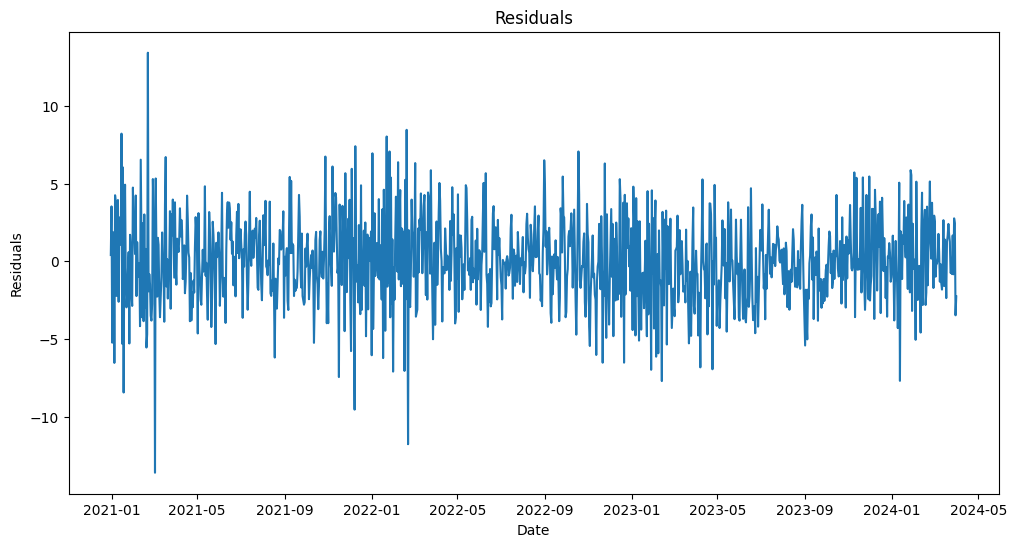

<Axes: title={'center': 'Residuals Kernel Denisity Function'}, xlabel='Date', ylabel='Density'>

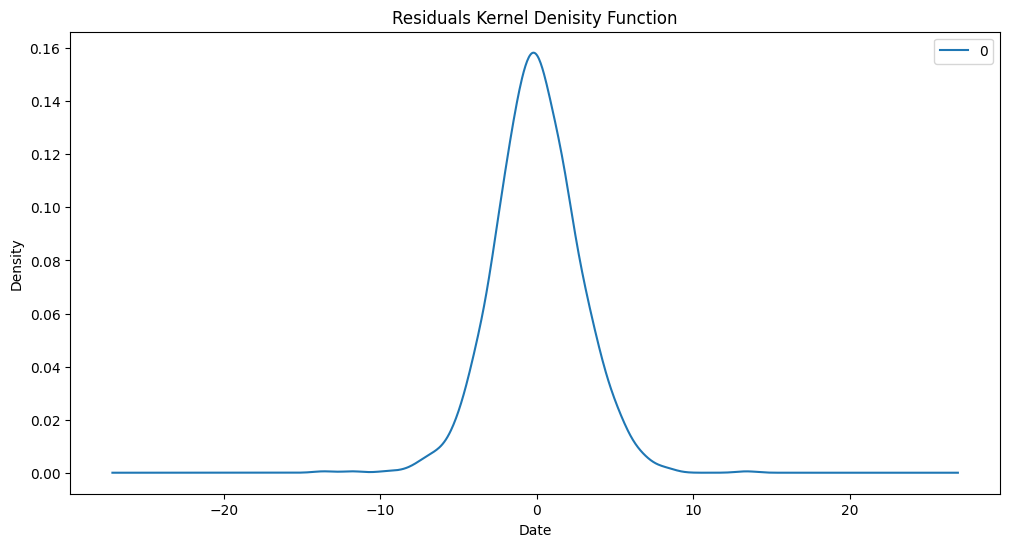

In [ ]:
resid_plots1 = plt.figure(figsize=(12, 6))
plt.plot(resid)
plt.title("Residuals", figure=resid_plots1)
plt.xlabel("Date", figure=resid_plots1)
plt.ylabel("Residuals", figure=resid_plots1)
plt.show()

resid_plots2 = plt.figure(figsize=(12, 6))
ax = resid_plots2.add_subplot(111)
plt.title("Residuals Kernel Density Function", figure=resid_plots2)
plt.xlabel("Date", figure=resid_plots2)
resid.plot(kind='kde', ax=ax)

<Axes: title={'center': 'Rolling Variance of Residuals'}, xlabel='date'>

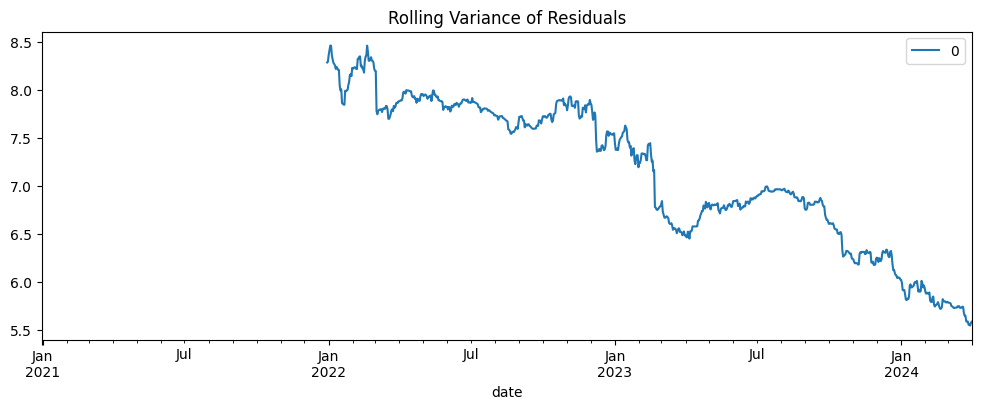

In [ ]:
rolling_var = resid.rolling(window=365).var()
rolling_var.plot(figsize=(12,4), title='Rolling Variance of Residuals')

In [ ]:
def shapiro_normality_test(data):
    p_value = shapiro(data)[1]
    if p_value >= 0.05:
        print("Data follows normal distribution: X~N"+ str((np.round(np.mean(data),3), np.round(np.std(data),3))))
        print("Shapiro test p_value={}".format(np.round(p_value,3)))
    else:
        print("Data failed shapiro normality test with p_value={}".format(p_value))

shapiro_normality_test(resid)

from statsmodels.stats.stattools import jarque_bera

def jarque_bera_normality_test(data):
    jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(data)

    # Convert to Python floats for clean formatting
    jb_stat = float(jb_stat)
    jb_pvalue = float(jb_pvalue)
    skew = float(skew)
    kurtosis = float(kurtosis)

    if jb_pvalue >= 0.05:
        print("Data follows a normal distribution: X ~ N({}, {})".format(
            np.round(np.mean(data), 3), np.round(np.std(data), 3)))
        print("Jarque-Bera test p-value = {:.4f}".format(jb_pvalue))
        print("Skewness = {:.4f}, Kurtosis = {:.4f}".format(skew, kurtosis))
    else:
        print("Data failed the Jarque-Bera normality test.")
        print("Jarque-Bera test p-value = {:.4f}".format(jb_pvalue))

        
jarque_bera_normality_test(resid)
        

Data failed shapiro normality test with p_value=3.030529342140653e-06


In [ ]:
# Fit GARCH(1,1) to residuals
garch_model = arch_model(resid.dropna(), vol='Garch', p=1, q=1)
garch_results = garch_model.fit()
print(garch_results.summary())

garch_residuals = garch_results.resid

Iteration:      1,   Func. Count:      6,   Neg. LLF: 963320227.954634
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4808.688133820429
Iteration:      3,   Func. Count:     22,   Neg. LLF: 4762.123195555162
Iteration:      4,   Func. Count:     30,   Neg. LLF: 2827.106902439529
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2820.7760689075885
Iteration:      6,   Func. Count:     41,   Neg. LLF: 2820.7760632409504
Iteration:      7,   Func. Count:     45,   Neg. LLF: 2820.776063240758
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2820.7760632409504
            Iterations: 7
            Function evaluations: 45
            Gradient evaluations: 7
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      0   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likeli

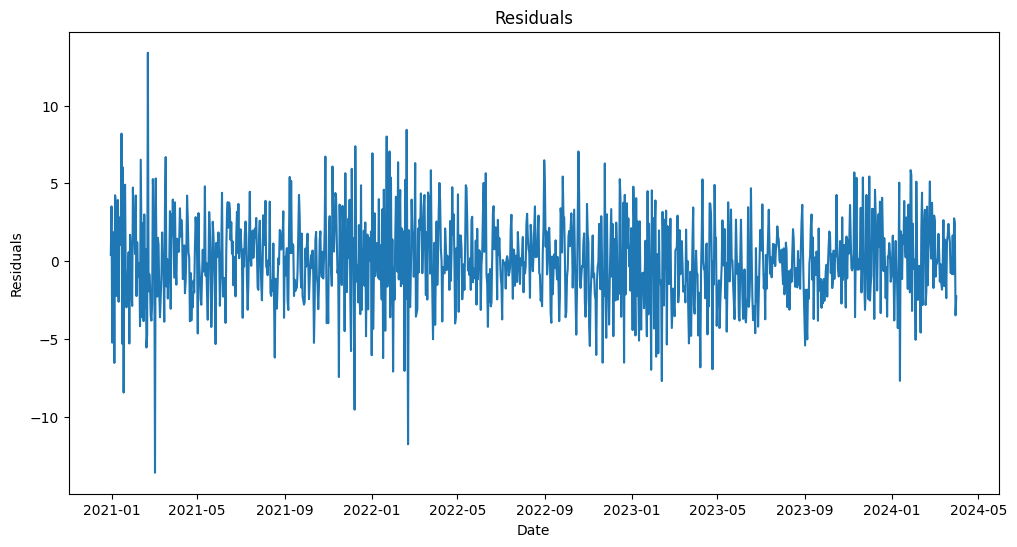

<Axes: title={'center': 'Residuals Kernel Denisity Function'}, xlabel='Date', ylabel='Density'>

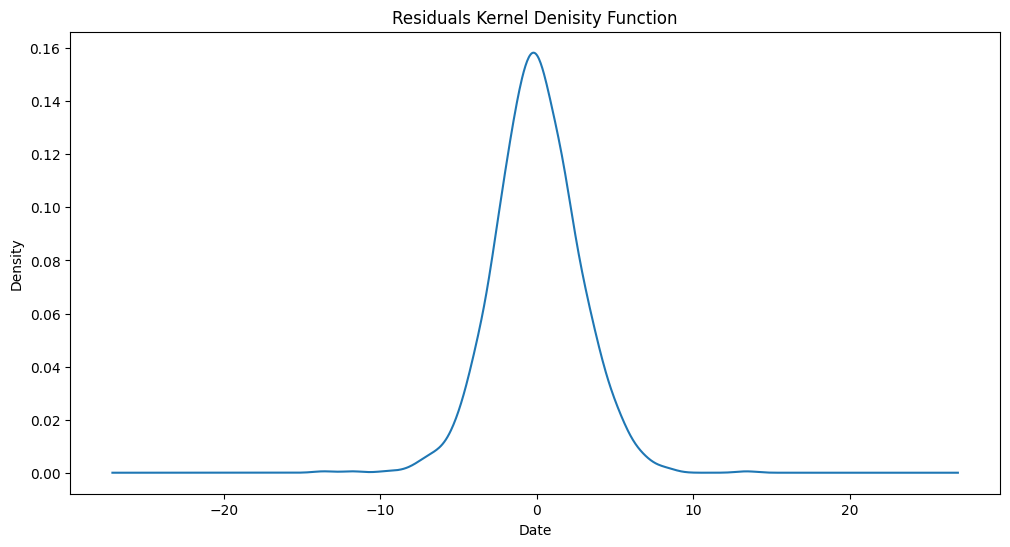

In [ ]:
resid_plots1 = plt.figure(figsize=(12, 6))
plt.plot(garch_residuals)
plt.title("Residuals", figure=resid_plots1)
plt.xlabel("Date", figure=resid_plots1)
plt.ylabel("Residuals", figure=resid_plots1)
plt.show()

resid_plots2 = plt.figure(figsize=(12, 6))
ax = resid_plots2.add_subplot(111)
plt.title("Residuals Kernel Denisity Function", figure=resid_plots2)
plt.xlabel("Date", figure=resid_plots2)
garch_residuals.plot(kind='kde', ax=ax)

In [ ]:
shapiro_normality_test(garch_residuals)

Data failed shapiro normality test with p_value=3.030529342140653e-06


In [ ]:
jarque_bera_normality_test(garch_residuals)

Data failed the Jarque-Bera normality test.
Jarque-Bera test p-value = 0.0000


In [ ]:
# Forecast h steps ahead with SARIMA
h = 30  # Forecast horizon (e.g., 30 days)
sarima_forecast = sarima_results.get_forecast(steps=h)
mean_forecast = sarima_forecast.predicted_mean
conf_int = sarima_forecast.conf_int()

In [ ]:
# GARCH on residuals
garch_forecast = garch_results.forecast(horizon=h)
variance_forecast = garch_forecast.variance.values[-1]

simulated_forecast = mean_forecast + np.random.normal(loc=0, scale=np.sqrt(variance_forecast))

/opt/anaconda3/envs/weather_deriv/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [ ]:
test_data = pd.read_csv('Data/test_data.csv')
test_data['date'] = pd.to_datetime(test_data['date'])
test_data.set_index('date', inplace=True)
test_data = test_data.resample('D').asfreq().fillna(method='ffill')

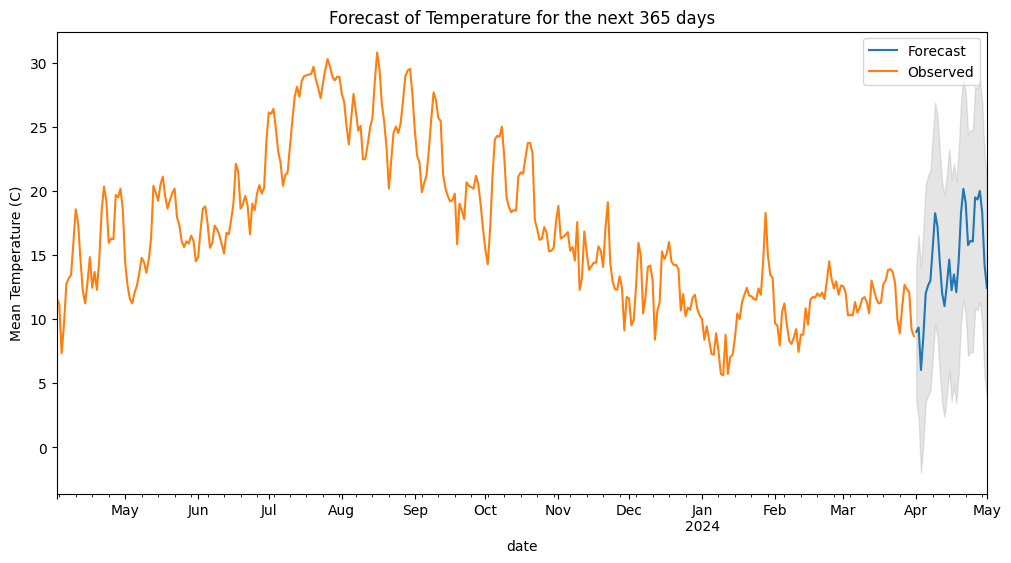

In [ ]:
forecast_length = 31

future_dates = pd.date_range(start=train_data.index[-1] + dt.timedelta(days=1), periods=forecast_length, freq='D')
future_df = pd.DataFrame(index=future_dates, columns=train_data.columns)

future_df["forecast"] = sarima_results.predict(start=future_dates[0], end=future_dates[-1], dynamic= False)
plot_length = 365

forecast_test_data_plot = plt.figure(figsize=(12, 6))
ax = forecast_test_data_plot.add_subplot(111)
plt.title(f'Forecast of Temperature for the next {365} days', figure=forecast_test_data_plot)
plt.xlabel('Date', figure=forecast_test_data_plot)
plt.ylabel('Mean Temperature (C)', figure=forecast_test_data_plot)
future_df["forecast"].plot(ax=ax, label='Forecast')
train_data['mean'][-plot_length:].plot(ax=ax, label='Observed')
plt.fill_between(future_df.index, 
                 sarima_results.get_forecast(steps=forecast_length).conf_int()['lower mean'], 
                 sarima_results.get_forecast(steps=forecast_length).conf_int()['upper mean'], 
                 color='gray', alpha=0.2)
plt.legend()
plt.show()
plt.show()


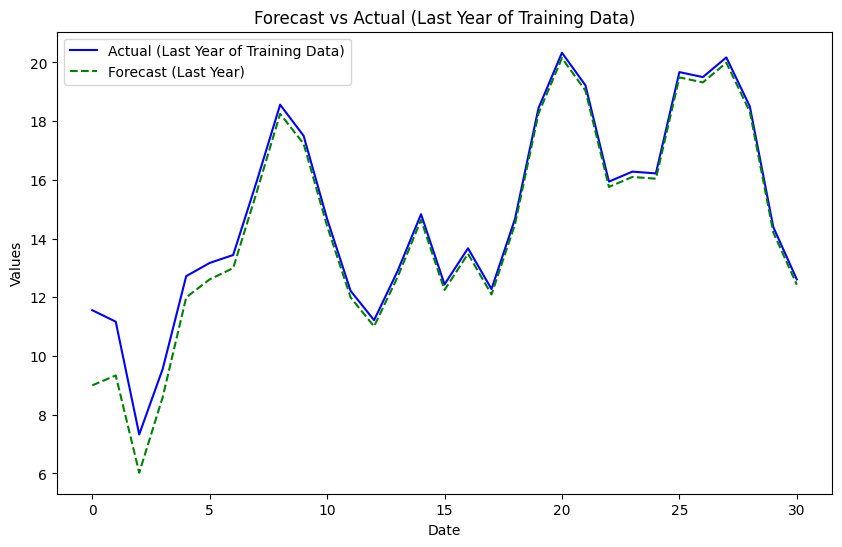

In [ ]:
# Extract the last year of the training data
last_year = train_data['mean'][-365:- 365 + forecast_length]  # Adjust the slicing based on your data's frequency (e.g., daily, monthly)
last_year.reset_index(drop=True, inplace=True)
# Generate the forecast for the same period as the last year of training data
test = future_df["forecast"].reset_index(drop=True)

# Plot the actual data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(last_year.index, last_year, label="Actual (Last Year of Training Data)", color="blue")
plt.plot(last_year.index, test, label="Forecast (Last Year)", color="green", linestyle="--")
plt.title("Forecast vs Actual (Last Year of Training Data)")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.show()

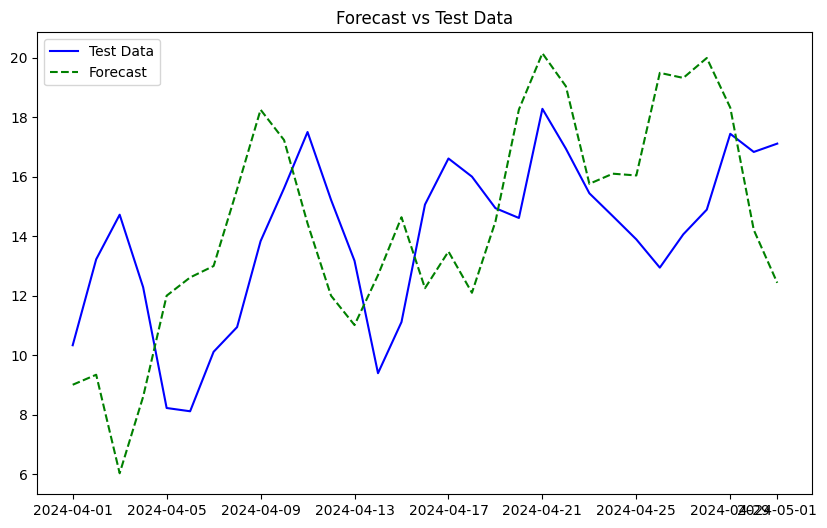

In [ ]:
# Plot the forecast against the test data
plt.figure(figsize=(10, 6))
plt.plot(test_data['mean'][:forecast_length], label="Test Data", color="blue")

# Align the index of the test Series with test_data
test.index = test_data[:forecast_length].index

plt.plot(test, label="Forecast", color="green", linestyle="--")
plt.title("Forecast vs Test Data")
plt.legend()
plt.show()


In [ ]:
#Calculate the RMSE and MAE and MASE
def calculate_errors(test, forecast):
    rmse = np.sqrt(np.mean((test - forecast) ** 2))
    mae = np.mean(np.abs(test - forecast))
    mase = mae / np.mean(np.abs(np.diff(test)))
    
    return rmse, mae, mase
rmse, mae, mase = calculate_errors(test_data['mean'][:31], test)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MASE: {mase}")

RMSE: 3.7133652767000727
MAE: 3.277346873653671
MASE: 1.886423756899657


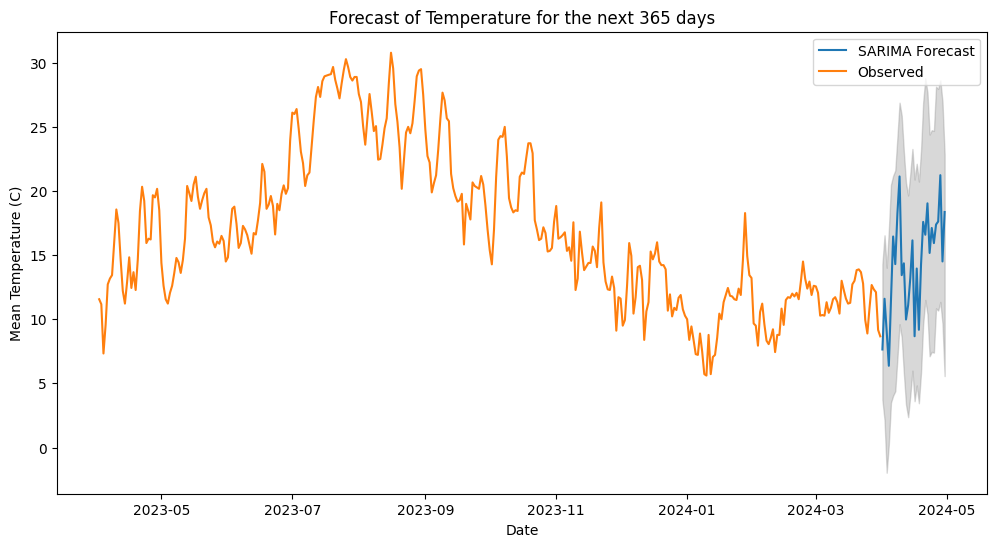

In [ ]:
forecast_test_data_plot = plt.figure(figsize=(12, 6))
ax = forecast_test_data_plot.add_subplot(111)
plt.title(f'Forecast of Temperature for the next {365} days', figure=forecast_test_data_plot)
plt.xlabel('Date', figure=forecast_test_data_plot)
plt.ylabel('Mean Temperature (C)', figure=forecast_test_data_plot)
plt.plot(simulated_forecast.index, simulated_forecast, label='SARIMA Forecast')
plt.plot(train_data.index[-365:], train_data['mean'][-365:], label='Observed')
plt.fill_between(simulated_forecast.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3)
plt.legend()
plt.show()


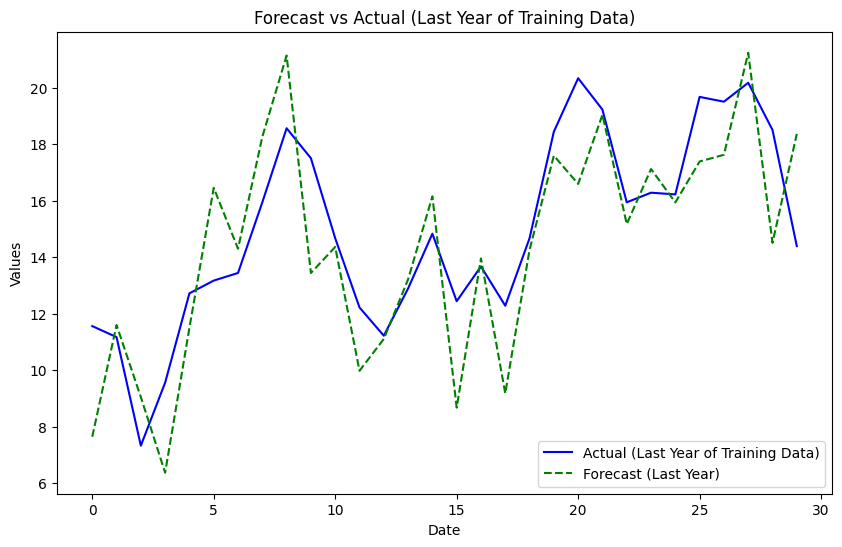

In [ ]:
# Extract the last year of the training data
last_year = train_data['mean'][-365:- 365 + forecast_length-1]  # Adjust the slicing based on your data's frequency (e.g., daily, monthly)
last_year.reset_index(drop=True, inplace=True)
# Generate the forecast for the same period as the last year of training data
test = simulated_forecast.reset_index(drop=True)

# Plot the actual data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(last_year.index, last_year, label="Actual (Last Year of Training Data)", color="blue")
plt.plot(last_year.index, test, label="Forecast (Last Year)", color="green", linestyle="--")
plt.title("Forecast vs Actual (Last Year of Training Data)")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.show()

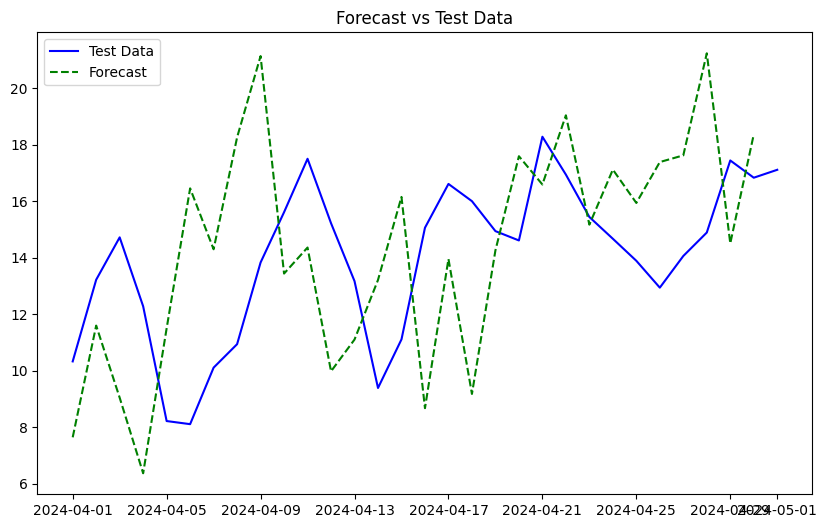

In [ ]:
# Plot the forecast against the test data
plt.figure(figsize=(10, 6))
plt.plot(test_data['mean'][:forecast_length], label="Test Data", color="blue")

# Align the index of the test Series with test_data
test.index = test_data[:forecast_length-1].index

plt.plot(test, label="Forecast", color="green", linestyle="--")
plt.title("Forecast vs Test Data")
plt.legend()
plt.show()


In [ ]:
#Calculate the RMSE and MAE and MASE
def calculate_errors(test, forecast):
    rmse = np.sqrt(np.mean((test - forecast) ** 2))
    mae = np.mean(np.abs(test - forecast))
    mase = mae / np.mean(np.abs(np.diff(test)))
    
    return rmse, mae, mase
rmse, mae, mase = calculate_errors(test_data['mean'][:31], test)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MASE: {mase}")

RMSE: 4.369830880138415
MAE: 3.823045419775039
MASE: 2.2005249921959167
